In [1]:
import logging
import os
import csv

import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core import Run, Workspace
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
import azureml.dataprep as dprep
from azureml.core.dataset import Dataset

In [2]:
# Load workspace
ws = Workspace.from_config()

In [3]:
# Choose a name for the run history container in the workspace.
experiment_name = '100by100'
project_folder = './project'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.28.0
Subscription ID,f375b912-331c-4fc5-8e9f-2d7205e3e036
Workspace Name,dicommodel
Resource Group,dicom-model-rg
Location,eastus
Project Directory,./project
Experiment Name,100by100


### Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for your AutoML run. In this tutorial, you create `AmlCompute` as your training compute resource.

**Creation of AmlCompute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace this code will skip the creation process.

As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "gpu-cluster"
compute_target = None
found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]

if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_NC6",
                                                                max_nodes = 4)
    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)

# For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Data

from azureml.core.datastore import Datastore
if 'datasets' in ws.datastores.keys():
    ds = ws.datastores['datasets']
else:
    account_key = os.getenv("ACCOUNT_KEY")
    ds = Datastore.register_azure_blob_container(ws, datastore_name='datasets', container_name='imagecontainer', 
                                             account_name='dicommodel2290602728', account_key=account_key, 
                                             resource_group='dicom-model-rg')

In [5]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

# get training dataset
training_dataset_name = experiment_name + "_training"
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    raise RuntimeError('Please use fhl_dicom_multiclass_create_labeled_datasets.ipynb to create labeled dataset for training.')

print("Training dataset name: " + training_dataset.name)

# get test dataset
test_dataset_name = experiment_name + "_test"
if test_dataset_name in ws.datasets:
    test_dataset = ws.datasets.get(test_dataset_name)
    print('Found the test dataset', test_dataset_name)
else:
    raise RuntimeError('Please use fhl_dicom_multiclass_create_labeled_datasets.ipynb to create labeled dataset for training.')

print("Test dataset name: " + test_dataset_name)


Found the training dataset 100by100_training
Training dataset name: 100by100_training
Found the test dataset 100by100_test
Test dataset name: 100by100_test


# Training runs

In [6]:
automl_settings = {
    "deterministic": True,
    "enable_dnn": True,
    "featurization": "off",
    "iteration_timeout_minutes": 120,
    "iterations": 1,
    "log_verbose_metrics": True,
    "primary_metric": "accuracy",
    "print_local_package_versions": True,
    "seed" : 47,
    "verbosity": logging.INFO
}

if os.getenv("SCENARIO"):
    automl_settings["scenario"] = os.getenv("SCENARIO")

automl_config = AutoMLConfig(task = 'image-classification',
                             debug_log = 'automl_errors.log',
                             path = project_folder,
                             compute_target=compute_target,
                             training_data=training_dataset,
                             # validation_data=validation_dataset,
                             **automl_settings
                            )

In [7]:
remote_run = experiment.submit(automl_config, show_output = False)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
100by100,AutoML_a9071e06-ce7a-4483-82fa-d63abffb49fb,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [8]:
remote_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_a9071e06-ce7a-4483-82fa-d63abffb49fb',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-05-27T00:44:19.730804Z',
 'endTimeUtc': '2021-05-27T03:39:45.979208Z',
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"100by100","subscription_id":"f375b912-331c-4fc5-8e9f-2d7205e3e036","resource_group":"dicom-model-rg","workspace_name":"dicommodel","region":"eastus","compute_target":"gpu-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":"accuracy","task_type":"image-classification","data

# Inference runs

In [9]:
# Load training script run corresponding to AutoML run above.
training_run_id = remote_run.id + "_HD_0"
training_run = Run(experiment, training_run_id)

In [10]:
 remote_run.id

'AutoML_a9071e06-ce7a-4483-82fa-d63abffb49fb'

In [11]:
# Inference script run arguments
arguments = [
        "--run_id", training_run_id,
        "--experiment_name", experiment.name,
        "--input_dataset_id", test_dataset.id
    ]

In [12]:
import tempfile
from azureml.core.script_run_config import ScriptRunConfig

output_prediction_file = "./outputs/predictions.txt"
scoring_args = arguments + ["--output_file", output_prediction_file]
with tempfile.TemporaryDirectory() as tmpdir:
    # Download required files from training run into temp folder.
    entry_script_name = "score_script.py"
    output_path = os.path.join(tmpdir, entry_script_name)
    training_run.download_file("train_artifacts/" + entry_script_name, os.path.join(tmpdir, entry_script_name))
    
    script_run_config = ScriptRunConfig(source_directory=tmpdir,
                                        script=entry_script_name,
                                        compute_target=compute_target,
                                        environment=training_run.get_environment(),
                                        arguments=scoring_args)
    scoring_run = experiment.submit(script_run_config)  

In [13]:
scoring_run.wait_for_completion(wait_post_processing=True)

{'runId': '100by100_1622086790_52811ae4',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-05-27T03:39:58.246965Z',
 'endTimeUtc': '2021-05-27T03:42:42.968733Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f086b751-35a1-4eae-9c68-2d95e8c47249',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json',
  'labeled_dataset_id': '66c62e16-d5e9-4ae2-a7ea-4c5fa5e1e83b'},
 'inputDatasets': [{'dataset': {'id': 'bc69d1e3-2f54-420d-856d-69de440e3815'}, 'consumptionDetails': {'type': 'Reference'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'score_script.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--run_id',
   'AutoML_a9071e06-ce7a-4483-82fa-d63abffb49fb_HD_0',
   '--experiment_name',
   '100by100',
   '--input_dataset_id',
   'bc69d1e3-2f54-420d-856d-69de440e3815',
   '--output_file',
   './outputs/predictions.txt'],
  'sourceDirectoryDataStore

# Get Prediction Results

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import json

# creating prediction dictionary
predicted_labels_with_filename = {}
scoring_run.download_file(output_prediction_file, output_file_path=output_prediction_file)
with open(output_prediction_file) as predictions:
    predict_str = predictions.readline()
    target_class_mit_indoor = json.loads(predict_str)["labels"]
    while predict_str: 
        prediction_json_line = json.loads(predict_str)
        labels = prediction_json_line["labels"]
        probs = prediction_json_line["probs"]

        max_prob = max(probs)
        max_index = probs.index(max_prob)
        label_with_max_prob = labels[max_index]
        
        predicted_labels_with_filename[prediction_json_line["filename"]] = label_with_max_prob
        predict_str = predictions.readline()

#print("dict: {}".format(predicted_labels_with_filename))

# Get Groud Truth

In [27]:
default_ds = ws.datastores['workspaceblobstore']
image_class_list_file_path = 'fhl/datasets/'+ experiment_name + '/label/labeleddatapoints_test.jsonl'

In [28]:
# creating groudtruth dictionary
default_ds.download('.', prefix=image_class_list_file_path, overwrite=True)

with open(image_class_list_file_path) as fp:
    number_of_lines_in_validation_dataset = len(fp.readlines())
    print("Number of lines in validation dataset: {}".format(number_of_lines_in_validation_dataset))

ground_truth_with_filename = {}
with open(image_class_list_file_path) as ground_truth:
    ground_truth_str = ground_truth.readline()
    while ground_truth_str:
        ground_truth_json_line = json.loads(ground_truth_str)
        ground_truth_with_filename[ground_truth_json_line["image_url"].replace("AmlDatastore://", "")] = ground_truth_json_line["label"]
        ground_truth_str = ground_truth.readline()

#print("ground_truth_str: {}".format(ground_truth_with_filename))

Downloaded fhl/datasets/100by100/label/labeleddatapoints_test.jsonl, 1 files out of an estimated total of 1
Number of lines in validation dataset: 5337


# Confusion Matrix

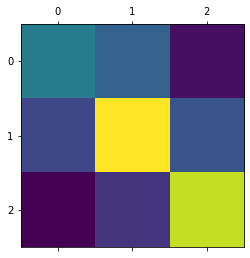

In [29]:
assert len(ground_truth_with_filename) == len(predicted_labels_with_filename)

y_pred = []
y_true = []
for filename in predicted_labels_with_filename.keys():
    if filename in ground_truth_with_filename.keys():
        y_pred.append(predicted_labels_with_filename[filename])
        y_true.append(ground_truth_with_filename[filename])
    else:
        print('Missing {} in ground trouth'.format(filename))

plt.matshow(confusion_matrix(y_true, y_pred, labels=target_class_mit_indoor))

In [30]:
print(classification_report(y_true, y_pred, target_names = target_class_mit_indoor))

                              precision    recall  f1-score   support

                Lung Opacity       0.65      0.54      0.59      1256
No Lung Opacity / Not Normal       0.68      0.67      0.68      2371
                      Normal       0.75      0.85      0.79      1710

                    accuracy                           0.70      5337
                   macro avg       0.69      0.69      0.69      5337
                weighted avg       0.69      0.70      0.69      5337

